In [12]:
import matplotlib.pyplot as plt

import numpy as np

import cv2
import time
from skimage import color, transform
from skimage.feature import hog
import imutils

import joblib

positive_patches_shape = (62, 47)

# Chargement du modèle
filename = 'temp_model2.sav'
loaded_model = joblib.load(filename)

In [31]:
path_to_img = 'img/testset/1_aerosmith.jpg'

L'image étudiée est de taille (272, 392)


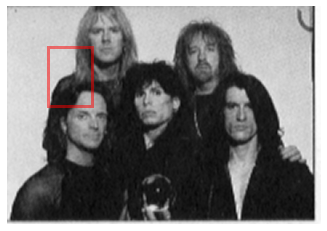

In [35]:
test_image = cv2.imread(path_to_img) 

test_image = color.rgb2gray(test_image)

(H_MAX, W_MAX) = (300, 600)

if test_image.shape[0] > H_MAX or test_image.shape[1] > W_MAX:
    s = min(H_MAX / test_image.shape[0], W_MAX / test_image.shape[1])
    test_image = transform.rescale(test_image, s)
    
test_image = test_image
    
print("L'image étudiée est de taille {}".format(test_image.shape))

scale = 1.2

Ni, Nj = (int(scale * e) for e in positive_patches_shape)

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
    
ax.add_patch(plt.Rectangle((50, 50), Nj, Ni, edgecolor='red', alpha=0.5, lw=3, facecolor='none'))

On a un total de 4000 patches.

100 zones positives trouvées.


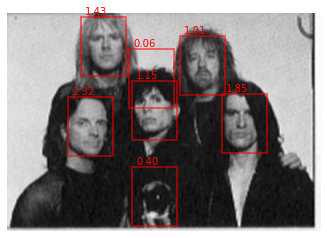


Temps d'exécution: 6.99 secondes



In [38]:
def sliding_window(img, patch_size, istep=4, jstep=4, scale=1.0):
    
    Ni, Nj = (int(scale * s) for s in patch_size)
    # La sliding window a une taille Ni*Nj
    
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
def non_max_suppression(boxes, h=66, w=52, seuil=0.3):
    if len(boxes) == 0:
        return []
    
    l = []
    
    y1 = boxes[:,0]
    x1 = boxes[:,1]
    y2 = h + y1
    x2 = w + x1
    
    # On calcule les aires des boxes
    aires = (x2 - x1 + 1) * (y2 - y1 + 1)    # le + 1 pour éviter la division par zéro
    
    indexes = boxes[:,2]
    
    indexes = np.argsort(indexes)
    
    while len(indexes) > 0:
        lst = len(indexes) - 1
        i = indexes[lst]
        l.append(i)
        
        # On cherche les intersections entre la box courante et toutes les autres
        y1_inter = np.maximum(y1[i], y1[indexes[:lst]])
        x1_inter = np.maximum(x1[i], x1[indexes[:lst]])
        y2_inter = np.minimum(y2[i], y2[indexes[:lst]])
        x2_inter = np.minimum(x2[i], x2[indexes[:lst]])
        
        h_inter = np.maximum(0, y2_inter - y1_inter + 1)
        w_inter = np.maximum(0, x2_inter - x1_inter + 1)
        aires_inter = (w_inter * h_inter)
   
        overlap = aires_inter / aires[indexes[:lst]]
        
        indexes = np.delete(indexes, np.concatenate(([lst], np.where(overlap > seuil)[0])))
        
    return boxes[l]
            
indices, patches = [], []

start = time.time()

indices, patches = zip(*sliding_window(test_image, positive_patches_shape, scale=scale))

print("On a un total de {} patches.".format(len(patches)))
    
indices = np.array(indices)
 
patches_hog = np.array([hog(patch) for patch in patches])

# Prédictions
labels = loaded_model.predict(patches_hog)

pred = []
for k in range(len(indices)):
    if labels[k] == 1:
        (i, j) = indices[k]
        pred.append((j, i, loaded_model.decision_function(patches_hog)[k]))

print("\n{} zones positives trouvées.".format(int(labels.sum())))

pred = np.array(pred)

nms_pred = non_max_suppression(pred, h=Ni, w=Nj, seuil=0.3)

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

for (j, i, conf) in nms_pred:
    rect = plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.5, lw=2, facecolor='none')
    ax.add_patch(rect)
    ax.text(j+5, i-3, f'{conf:.2f}', color='red')

plt.show()

fig.savefig("figure.png")

print("\nTemps d'exécution: {} secondes\n".format(round(time.time()-start, 2)))